# ODE Model of neurovascular coupling

The neurovascular unit (NVU) is modelled following [1] and a separate paper to the software is published in https://github.com/ReScience-Archives/Diem-2017 [2].

The model is used to calculate the dilatation of an arteriole due to functional hyperaemia, i.e. the communication of neuronal nutrient demand via astrocytes. This was used to develop the neurovascular coupling hypothesis for the driving force behind IPAD [3]. 

In [10]:
from nvu import nvu, utils
import numpy as np
import matplotlib.pylab as plt 

%matplotlib inline

plt.rcParams['axes.labelsize'] = 9
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = ['Arial']

WIDTH = 510
FACTOR = 1.0  # the fraction of the width you'd like the figure to occupy
fig_width_pt  = WIDTH * FACTOR
inches_per_pt = 1.0 / 72.27
golden_ratio  = (np.sqrt(5) - 1.0) / 2.0  # because it looks good
fig_width_in  = fig_width_pt * inches_per_pt  # figure width in inches
fig_height_in = fig_width_in * golden_ratio   # figure height in inches
fig_dims    = [fig_width_in, fig_height_in] # fig dims as a list
fig_dims_half = [fig_width_in, fig_height_in/2]

The model uses over 100 parameters, so we load them from file

In [2]:
units, param = utils.read_config("./nvu/parameter.cfg")

For the simulation we require the initial conditions for the 17 variables and an array to store the solution

In [3]:
def init(r0):
    potassium_s = 2.92655044308714e-8
    ip3 = 5.37611796987610e-10
    calcium_a = 1.47220569018281e-07
    h = 0.404507631346124
    ss = 0.0161921297424289
    eet = 4.78801348065449e-07
    nbk = 6.24930194169376e-5
    Vk = -0.0814061063457068
    potassium_p = 0.00353809145071707
    calcium_p = 4.60269585230500e-06
    k = 8.01125818473096e-09
    Vm = 8.33004194103223e-05
    n = 0.283859572906570
    x = 2*np.pi*r0
    calcium_smc = 3.41385670857693e-07
    omega = 0.536911672725179
    yy = 0.000115089683436595
    return [potassium_s, ip3, calcium_a, h, ss, eet, nbk, Vk, potassium_p,
            calcium_p, k, Vm, n, x, calcium_smc, omega, yy]

um = units['um']
r0 = 20*um # initial radius of the arteriole 
y0 = init(r0) # returns initial conditions for NVU model
x_rel = y0[13] # variable x (cross-sectional area) of relaxed arteriole
sol = np.zeros(len(y0)) # array to store solution

Set tolerance values for the solver. These were found by experimenting

In [6]:
atol = 1e-8
rtol = 1e-7

Communication with the authors revealed that an equilibration phase is required for the simulation

In [7]:
t1 = -20 # start time
t2 = 0 # end time
nt = 100 # time steps
Jrho_IN = np.zeros((nt,3)) # input array
Jrho_IN[:,0] = np.linspace(t1, t2, nt) # input
t = np.linspace(t1, t2, nt)
sol = nvu.run_simulation(t, y0, Jrho_IN, x_rel, units, param, atol=atol, rtol=rtol)
y0 = sol[-1,:] # set the result of the equilibration as the new initial condition

Now we can run the actual simulation

In [8]:
def K_glut_release(t1, t2, uM, s, **kwargs):
    # this function sets the input conditions - the release of K+ and Glu into the synapse
    sizeJrho = 1600
    sec = sizeJrho/(t2-t1)
    Max_neural_Kplus = 0.55*uM/s # max K+ value
    Max_neural_glut = 0.5 # max ratio of open/unopened Glu receptors
    # Jrho_IN holds input conditions:
    # Jrho_IN[:,0] is time, Jrho_IN[:,1] is K+, Jrho_IN[:,2] is Glu
    Jrho_IN = np.zeros((sizeJrho,3))
    Jrho_IN[:,0] = np.linspace(t1, t2, sizeJrho)
    pulse = 20
    it1 = int(0*sec) # phase 1
    it2 = int(pulse*sec) # phase 2 
    it3 = int((25-pulse)*sec) # phase 3
    it4 = int(1*sec) # phase 4
    pos = it1
    t = np.linspace(0, pulse, it2)
    # phase 1: no K+ or Glu
    # phase 2: sigmoidal increase of K+ and Glu
    Jrho_IN[pos+1:pos+it2+1,1] = Max_neural_Kplus * 0.5*(1 + np.tanh((t-9)/3))
    Jrho_IN[pos+1:pos+it2+1,2] = Max_neural_glut * 0.5*(1 + np.tanh((t-9)/3))
    pos += it2
    # phase 3: keep K+ and Glu at max values
    Jrho_IN[pos+1:pos+it3+1,1] = Max_neural_Kplus * np.ones(it3)
    Jrho_IN[pos+1:pos+it3+1,2] = Max_neural_glut * np.ones(it3)
    pos += it3
    # phase 4: linear decrease of K+ and Glu to 0
    Jrho_IN[pos+1:pos+it4+1,1] = Max_neural_Kplus * np.linspace(1, 0, it4)
    Jrho_IN[pos+1:pos+it4+1,2] = Max_neural_glut * np.linspace(1, 0, it4)
    return Jrho_IN

t1 = 0 # start time
t2 = 50 # end time
nt = 200 # time steps
Jrho_IN = K_glut_release(t1, t2, **units) # input
t = np.linspace(t1, t2, nt)    
sol = nvu.run_simulation(t, y0, Jrho_IN, x_rel, units, param, atol=atol, rtol=rtol)

The NVU package comes with a function to plot the results

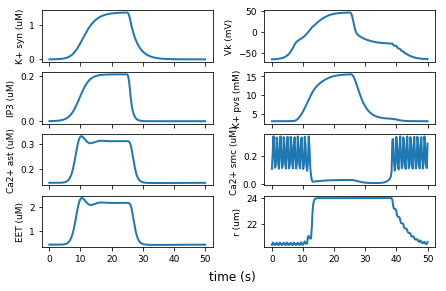

In [12]:
nvu.plot_solution(t, sol, fig_dims, **units)

## References

[1] Witthoft A, Karniadakis GE (2012) A bidirectional model for communication in the neurovascular unit. Journal of Theoretical Biology 311: 80-93. http://dx.doi.org/10.1016/j.jtbi.2012.07.014

[2] Diem AK (2017) [Re] A bidirectional model for communication in the neurovascular unit. ReScience 3: 11. https://github.com/ReScience-Archives/Diem-2017/blob/master/article/Diem-2017.pdf

[3] Diem AK, Carare RO, Weller RO, Bressloff NW (2017) A control mechanism for intramural periarterial drainage via astrocytes: How neuronal activity could improve waste clearance from the brain. arXiv preprint: https://arxiv.org/abs/1710.01117